In [1]:
# Importando bibliotecas #
import random
import pandas as pd
import matplotlib.pyplot as plt

carregando arquivo com as palavras que serão utilizadas no jogo

In [2]:
with open('br-sem-acentos.txt', 'r') as arquivo:
    r = arquivo.read()
    conteudo = str(r).lower().split('\n')

## Classe JogoDeForca 
A classe cria um jogo de forca no qual sorteia a palavra que deverá ser adivinhada e permite o jogador chutar letras, caso o jogador erre uma letra ele perde uma vida. O jogador pode adivinhar a palavra apenas uma vez, se ele acertar, ele ganha, caso contrário ele perde. Zerar as suas vidas também resulta na derrota

In [3]:
class JogoDeForca:
    def __init__(self, conteudo):
        '''Carrega o txt de palavras'''
        self.content = conteudo
        
    
    def novo_jogo(self, vidas=5):
        '''Novo jogo com uma palavra aleatória e 5 vidas (padrão)'''
        self.vidas = vidas
        self.palavra = random.choice(self.content)
        self.finalizado = False
        return len(self.palavra)


    def tentar_letra(self, letra):
        '''Tentativa de acertar uma das letras da palavra'''
        if self.vidas > 0:
            if letra in self.palavra:
                return [idx for idx in range(len(self.palavra)) if self.palavra[idx]==letra]
            else:
                self.vidas -= 1
                if self.vidas == 0:
                    return False
                else:
                    return []
        else:
            return False
        
    def tentar_palavra(self, palavra):
        '''Tenta adivinhar a palavra'''
        if self.vidas > 0:
            if self.palavra == palavra:
                return True
            else:
                self.vidas = 0
                return False
        else:
            self.finalizado = True

## Classe Jogador

Cria um jogador cujo objetivo é escolher a melhor letra possível para chutar no jogo da Velha

In [19]:
class Jogador:

    def __init__(self, conteudo) :
        self.conteudo = conteudo
        
    def inicializacao(self, n_letras):
        """ Inicializa um jogo novo """
        self.n_letras = n_letras
        self.letras_descartadas = ''
        self.letras_na_palavra = ''
        self.possivel_palavra = ['' for _ in range(n_letras)]
        self.palavras_possiveis = list(filter(lambda x: (len(x) == self.n_letras) , self.conteudo))
    
    def lista_palavras(self, resultado, l):
        """Filtra a lista de palavras de acordo com os chutes anteriores"""
        lista_nova = []
        if len(resultado) == 0:
            for p in self.palavras_possiveis:
                if l not in p:
                    lista_nova.append(p)
        else:
            for p in self.palavras_possiveis:
                pin = True
                if l in p:
                    for i in resultado:
                        if p[i] != l:
                            pin = False
                            break
                    if pin:
                        lista_nova.append(p)
                        
        self.palavras_possiveis = lista_nova
        
        return len(self.palavras_possiveis)
    
    def letra_mais_frequente(self):
        """Retorna a letra que mais aparece nas palavras"""
        texto = ''.join(self.palavras_possiveis)
        dicio = {}
        for c in set(texto):
            dicio[c] = texto.count(c)/len(texto)

        sortedDict = sorted(dicio.items(), key=lambda x:x[1])
        i = len(sortedDict) -1
        letra = sortedDict[i][0]
        while letra in self.letras_descartadas and i >0 :
            i -= 1
            letra = sortedDict[i][0]

        self.letras_descartadas += letra
        
        return letra
    
    def letra_mais_palavras(self, df):
        """Retorna a letra """
        filtro = df['palavra'].isin(self.palavras_possiveis)
        df = df[filtro]
        df_ = df.drop(['palavra'], axis=1)
        dicio = {}
        for c in df_.columns:
            try:
                dicio[c] = df_[c].value_counts()[1]/len(df)
            except:
                dicio[c] = 0


        sortedDict = sorted(dicio.items(), key=lambda x:x[1])
        i = len(sortedDict) -1
        letra = sortedDict[i][0]
        while letra in self.letras_descartadas and i >0 :
            i -= 1
            letra = sortedDict[i][0]

        self.letras_descartadas += letra
        
        return letra
    
    

        

In [6]:
class Relatorio:

    def __init__(self, n):
        self.qtd_vitorias = 0
        self.qtd_chutes = 0
        self.qtd_acerto_chute = 0
        self.palavras_chutadas = []
        self.n = n


    def tabela(self):
        df = pd.DataFrame()
        df['vitórias (qtd)'] = [self.qtd_vitorias]
        df['chutes (qtd)'] = [self.qtd_chutes]
        df['acertos no chute (qtd)'] = [self.qtd_acerto_chute]
        df['vitórias (%)'] = [self.qtd_vitorias / self.n]
        return df

    

Função que testa o jogador em `n` jogos com determinada estratégia

In [35]:
df_freq = pd.read_csv('frequencia1.csv')


def testa_jogada(n_iteracoes, estrategia):
    
    # verifica se o tipo de estratégia é válido
    if estrategia not in ['por_palavra', 'maior_freq']:
        return 'estratégia não existente'
    
    relatorio = Relatorio(n_iteracoes)

    jogo = JogoDeForca(conteudo) # cria o jogo
    jogador = Jogador(conteudo) # cria o jogador
    
    for _ in range(n_iteracoes):

        # inicializa 
        n_letras = jogo.novo_jogo()
        jogador.inicializacao(n_letras)
        
        while jogo.vidas > 0:

            # escolhe a letra de acordo com a estratégia
            if estrategia == 'por_palavra':
                l = jogador.letra_mais_palavras(df_freq)
            elif estrategia == 'maior_freq':
                l = jogador.letra_mais_frequente()

            # chuta a letra
            resultado = jogo.tentar_letra(l)
            
            # se o resultado for booleano significa que o jogo acabou 
            if type(resultado) == bool:
                r = resultado
                break
            else:
                # acertou a letra
                if len(resultado) != 0:
                    jogador.letras_na_palavra += l

                # renova a lista de palavras possíveis
                total_palavras = jogador.lista_palavras(resultado, l)

                # se só tem uma palavra possível
                if total_palavras == 1:
                    r = jogo.tentar_palavra(jogador.palavras_possiveis[0])
                    break

                # se é a última vida, o jogador chuta entre as palavras possíveis
                if jogo.vidas == 1:
                    relatorio.palavras_chutadas.append(jogo.palavra)
                    relatorio.qtd_chutes += 1
                    r = jogo.tentar_palavra(random.choice(jogador.palavras_possiveis))
                    if r: 
                        relatorio.qtd_acerto_chute += 1
                    break
        
        if r :
            relatorio.qtd_vitorias +=1

    return relatorio


estratégia de letra que aparece em mais palavras

In [21]:
relatorio1 = testa_jogada(100, 'por_palavra')
df1 = relatorio1.tabela()
df1.head()

,vitórias (qtd),chutes (qtd),acertos no chute (qtd),vitórias (%)
0,93,10,3,0.93


estratégia de letra que mais aparece nas palavras

In [22]:
relatorio2 = testa_jogada(100, 'maior_freq')
df2 = relatorio2.tabela()
df2.head()

,vitórias (qtd),chutes (qtd),acertos no chute (qtd),vitórias (%)
0,95,6,1,0.95


# Análise dos erros

In [23]:
relatorio_erros1 = testa_jogada(1000, 'por_palavra')
relatorio_erros2 = testa_jogada(1000, 'maior_freq')

In [24]:
erros = []
erros += relatorio_erros1.palavras_chutadas
erros += relatorio_erros2.palavras_chutadas

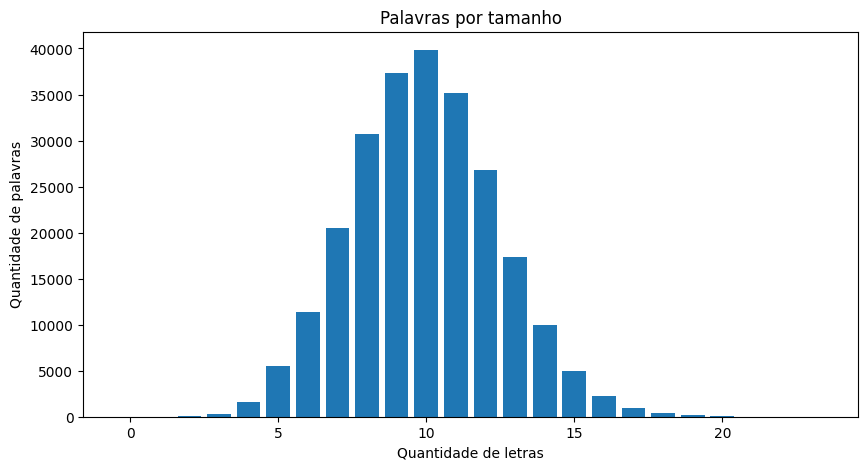

In [94]:
qtd_letras_geral = [len(p) for p in conteudo]
a = pd.Series(qtd_letras_geral)
b = a.value_counts()

plt.figure(figsize=(10,5))
plt.bar(b.index, b.values)
plt.xlabel('Quantidade de letras')
plt.ylabel('Quantidade de palavras')
plt.title('Palavras por tamanho')
plt.show()


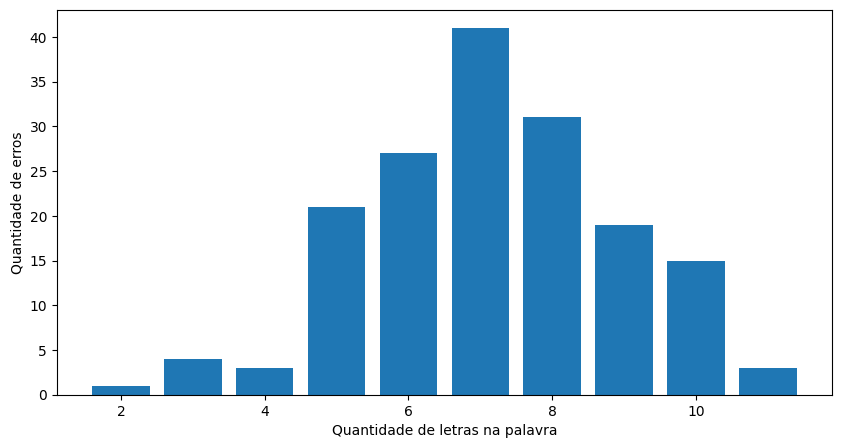

In [47]:
qtd_letras = [len(p) for p in erros]
m = pd.Series(qtd_letras)
n = m.value_counts()

plt.figure(figsize=(10,5))
plt.bar(n.index, n.values)
plt.ylabel('Quantidade de erros')
plt.xlabel('Quantidade de letras na palavra')
plt.show()


Vamos analisar algumas das palavras de 7 letras, já que essa quantidade é a que mais resultou em erros do nosso jogador!

In [77]:
palavras_7 = []
n = 0

for i in range(len(qtd_letras)):
    if n == 7:
        break
    if qtd_letras[i] == 7:
        palavras_7.append(erros[i])
        n += 1
    
    

In [103]:
df_freq = pd.read_csv('frequencia1.csv')

jogo = JogoDeForca(conteudo) # cria o jogo
jogador = Jogador(conteudo) # cria o jogador
qtd_palavras_no_final = []

df_erros = pd.DataFrame()
df_erros['palavra'] = []
df_erros['letras chutadas'] = []
df_erros['conhecimento da palavra'] = []
df_erros['qtd palavras restantes'] = []
df_erros['palavras restantes'] = []


for p in range(len(palavras_7)):
    # inicializa 
    n_letras = jogo.novo_jogo()
    jogo.palavra = palavras_7[p]
    n_letras = 7
    jogador.inicializacao(n_letras)
    conhecimento = ['' for i in range(7)]

    while jogo.vidas > 0:

        # escolhe a letra de acordo com a estratégia
        l = jogador.letra_mais_frequente()
        

        # chuta a letra
        resultado = jogo.tentar_letra(l)
            
        # se o resultado for booleano significa que o jogo acabou 
        if type(resultado) == bool:
            r = resultado
            break
        else:
            # acertou a letra
            if len(resultado) != 0:
                jogador.letras_na_palavra += l
                for i in resultado:
                    conhecimento[i] = l


            # renova a lista de palavras possíveis
            total_palavras = jogador.lista_palavras(resultado, l)

            # se só tem uma palavra possível
            if total_palavras == 1:
                print('acertou!')
                r = jogo.tentar_palavra(jogador.palavras_possiveis[0])
                break

            # se é a última vida, o jogador chuta entre as palavras possíveis
            if jogo.vidas == 1:
                df_erros.loc[p] = [jogo.palavra, jogador.letras_descartadas, conhecimento, len(jogador.palavras_possiveis),jogador.palavras_possiveis]
                qtd_palavras_no_final.append(len(jogador.palavras_possiveis))
                r = jogo.tentar_palavra(random.choice(jogador.palavras_possiveis))
                break


In [104]:
print(f'Quantidade de palavras com 7 letras: {qtd_letras_geral.count(7)}')

df_erros.head()

Quantidade de palavras com 7 letras: 20548


,palavra,letras chutadas,conhecimento da palavra,qtd palavras restantes,palavras restantes
0,caiarao,asrmoclv,"[c, a, , a, r, a, o]",5,"[cacarao, cagarao, caiarao, caparao, catarao]"
1,jornais,aormdsitc,"[, o, r, , a, i, s]",7,"[boreais, borrais, forjais, forrais, jornais, ..."
2,ofendeu,aesri,"[, , e, , , e, ]",8,"[cheguem, chequem, efetuem, emendem, enevoem, ..."
3,coalham,arismlt,"[, , a, l, , a, m]",3,"[acalmam, apalpam, coalham]"
4,alvejam,arismn,"[a, , , , , a, m]",32,"[abotoam, acalmam, acampam, achavam, achegam, ..."


Apartir desses dados pode-se afirmar que apesar do jogador ter diminuido drasticamente o número de palavras possíveis, no final de suas vidas ele ainda não tinha informação o suficiente para acertar a palavra. 

Isso acontece, pois existem palavras nesse vocabulário que possuem um grande número de letras não apenas em comum, como também posicionadas na mesma posição como é o caso de "caiarao" e cacarao, cagarao, caiarao, caparao, catarao. Esse semelhança entre as palavras impede que a palavra seja descoberta com um número tão limitado de vidas (5).
